<h1> Performance Metrics </h1>

In this notebook, we will load in a trained multiclass LSTM model and evaluate it's performance. 

In [1]:
import sys;
import subprocess;
import numpy as np
import pandas as pd

from get_labels import get_labels
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split

import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers import LSTM

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


<h4> Load training data and labels. </h4>
We will load the same data used in training our LSTM model but keep only the test splits this time. The random seed of 1024 has been used to ensure we get the same splits as when training the model. We include the same multiclass_loss function as before so that the model is loaded properly.

In [2]:
labels = get_labels();
labels_array = np.array([x for x in labels]);
labels_reshaped = labels_array.reshape(1851243, 1, 1070);

/home/ubuntu/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
train_x = joblib.load("/mnt/cleaned_tfidf_reduced_420_morning");
train_x_reshaped = train_x.reshape(1851243,1,1000);

In [4]:
x_train, x_test, y_train, y_test = train_test_split(train_x_reshaped, labels_reshaped, test_size=0.20, random_state=1024)

In [21]:
#Our custom loss function
def multiclass_loss(y_true, y_pred):
    EPS = 1e-5
    y_pred = K.clip(y_pred, EPS, 1 - EPS)
    return -K.mean((1 - y_true) * K.log(1 - y_pred) + y_true * K.log(y_pred))

model = load_model('khot_LSTM_1353.h5', custom_objects={"multiclass_loss":multiclass_loss})

Delete unused variables to clean up memory. This should free around 60 GiB. 

In [6]:
del labels
del labels_array
del labels_reshaped

del train_x
del train_x_reshaped

del x_train
del y_train

For every x_test sample, predict the ICD_9 labels using our loaded model. Save both the samples and true test labels to flattened arrays for our performance metrics.

In [22]:
def get_preds_array():
    all_test = [];
    all_preds = [];
    all_preds_proba = [];
    
    for idx, test_val in enumerate(x_test):
        y_test_val = y_test[idx];
        
        k = len(y_test_val[y_test_val == 1])
        
        pred_val = model.predict(test_val.reshape(1,1,1000))[0][0]
        topk = pred_val.argsort()[-1 * k:][::-1]

        pred_arr = np.zeros(y_test_val.shape);
        pred_arr[0,topk] = 1;
        
        all_test.extend(y_test_val[0]);
        all_preds.extend(pred_arr[0]);
        all_preds_proba.extend(pred_val); # commend out this line to disable probabilty predictions
        
        if idx % 500 == 0:
            sys.stdout.write('\rOn ' + str(idx) + ' / ' + str(len(x_test)));
            
    return (all_preds, all_test, all_preds_proba);

(all_preds, all_test, all_preds_proba) = get_preds_array();

On 370000 / 370249

In [ ]:
#joblib.dump((all_preds, all_test), 'predictions_test.pkl')

Convert predictions and tests to numpy arrays and continue to clean up memory. Finally, print the sum of the arrays. These should be equal because we set the count of 1's in our predictions to be equal to the count of 1's in our actual values. 

In [23]:
preds_arr = np.array(all_preds);
#del all_preds

test_arr = np.array(all_test);
#del all_test

preds_proba_arr = np.array(all_preds_proba)
#del (all_preds_proba)

In [24]:
print(np.sum(preds_arr));
print(np.sum(test_arr));

4645257.0
4645257.0


<h4> Performance Metrics </h4>
Below we have a series of methods used to measure the performance of our model at prediciting ICD_9 codes. 

In [25]:
def tp_rate(predictions, actuals, get_rate=True):
    sums = predictions + actuals;
    all2s = sums[sums == 2];
    if get_rate:
        #return len(all2s) / float(sum(sums));
        return len(all2s) / float(len(sums));
    else:
        return len(all2s);

In [26]:
def fp_rate(predictions, actuals, get_rate=True):
    act_not = np.logical_not(actuals).astype(int);
    return tp_rate(predictions, act_not, get_rate);

In [27]:
def fn_rate(predictions, actuals, get_rate=True):
    pred_not = np.logical_not(predictions).astype(int);
    return tp_rate(pred_not, actuals, get_rate);

In [28]:
def tn_rate(predictions, actuals, get_rate=True):
    pred_not = np.logical_not(predictions).astype(int);
    act_not = np.logical_not(actuals).astype(int);
    return tp_rate(pred_not, act_not, get_rate);

In [29]:
def accuracy(predictions, actuals):
    tp_val = tp_rate(predictions, actuals, False);
    tn_val = tn_rate(predictions, actuals, False);
    
    return (tp_val + tn_val) / float(len(predictions));

In [30]:
def precision(predictions, actuals, get_rate=True):
    tp = tp_rate(predictions, actuals, get_rate);
    fp = fp_rate(predictions, actuals, get_rate);
    return (float(tp) / (tp + fp));

In [31]:
def recall(predictions, actuals, get_rate=True):
    tp = tp_rate(predictions, actuals, get_rate);
    fn = fn_rate(predictions, actuals, get_rate);
    
    return (tp / float(tp + fn));

In [64]:
def confusion_array(predictions, actuals, get_rate=True):
    fp = fp_rate(predictions, actuals, get_rate);
    tp = tp_rate(predictions, actuals, get_rate);
    fn = fn_rate(predictions, actuals, get_rate);
    tn = tn_rate(predictions, actuals, get_rate);
    
    conf = np.array([[tp, fp], [fn, tn]]);

    conf_pdf = pd.DataFrame(conf);
    conf_pdf.columns = ['Condition True', 'Condition False'];
    conf_pdf = conf_pdf.set_index(np.array(['Predicted True', 'Predicted False']))
    
    return conf_pdf;

In [33]:
conf_vals = confusion_array(preds_arr, test_arr, False)
conf_arr = confusion_array(preds_arr, test_arr)
acc_val = accuracy(preds_arr, test_arr);
precision_val = precision(preds_arr, test_arr);
recall_val = recall(preds_arr, test_arr);

In [67]:
print ("Confusion matrix:")
conf_vals

Confusion matrix:


,Condition True,Condition False
Predicted True,2098867,2546390
Predicted False,2546390,388974783


In [69]:
print ("Confusion rate matrix:")
conf_arr

Confusion rate matrix:


,Condition True,Condition False
Predicted True,0.005298,0.006428
Predicted False,0.006428,0.981847


In [70]:
print ("Our values: \n\t accuracy: %f \n\t prcision: %f \n\t recall: %f" % (acc_val, precision_val, recall_val))

Our values: 
	 accuracy: 0.987145 
	 prcision: 0.451830 
	 recall: 0.451830


For comparison, we also use sklearn's built in metrics. 

In [ ]:
sklearn_accuracy = metrics.accuracy_score(test_arr, preds_arr)
sklearn_precision = metrics.precision_score(test_arr, preds_arr)
sklearn_recall = metrics.recall_score(test_arr, preds_arr)
sklearn_f1 = metrics.f1_score(test_arr, preds_arr)
sklearn_roc = metrics.roc_auc_score(test_arr, preds_proba_arr)
sklearn_conf_matrix = metrics.confusion_matrix(test_arr, preds_arr)

In [52]:
print ("Sklearn accuracy:", sklearn_accuracy)
print ("Sklearn precision:", sklearn_precision)
print ("Sklearn recall:", sklearn_recall)
print ("Sklearn f1 score:", sklearn_f1)
print ("sklearn roc:", sklearn_roc)
print ("sklearn confusion matrix", sklearn_conf_matrix)

('Sklearn accuracy:', 0.98714484717950479)
('Sklearn precision:', 0.45183011402813666)
('Sklearn recall:', 0.45183011402813666)
('Sklearn f1 score:', 0.45183011402813666)
('sklearn roc:', 0.72266313837517526)
('sklearn confusion matrix', array([[388974783,   2546390],
       [  2546390,   2098867]]))


In [37]:
def plot_roc(y_test, predictions):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC')
    plt.legend(loc="lower right")
    plt.show()


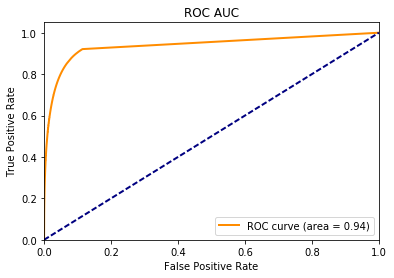

In [38]:
plot_roc(test_arr, preds_proba_arr)